In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv -O housing.csv

--2023-09-21 11:24:01--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/housing.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1423529 (1,4M) [text/plain]
Saving to: ‘housing.csv’

housing.csv         100%[===================>]   1,36M  --.-KB/s    in 0,1s    

2023-09-21 11:24:01 (11,1 MB/s) - ‘housing.csv’ saved [1423529/1423529]



# Preperation

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 

%matplotlib inline
df = pd.read_csv('housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


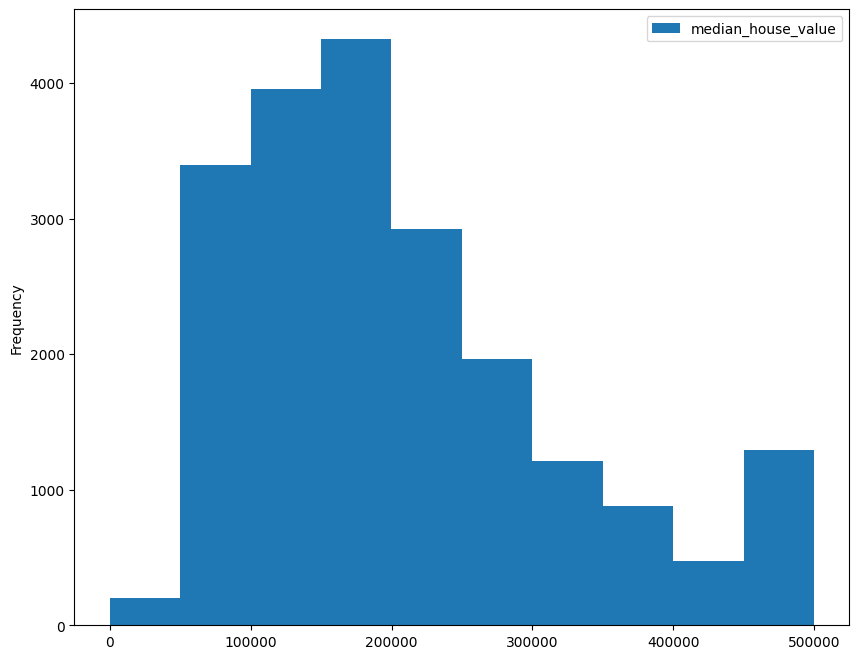

In [3]:
ax = df.plot.hist(column=["median_house_value"], figsize=(10, 8))

In [4]:
def clean(df):
    _df = df[(df.ocean_proximity == '<1H OCEAN') | (df.ocean_proximity == 'INLAND')]
    _df = _df[
        ['latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income',
        'median_house_value']
    ]  
    return _df

df_clean = clean(df)
df_clean.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
701,37.64,-121.97,32.0,1283.0,194.0,485.0,171.0,6.0574,431000.0
830,37.61,-121.99,9.0,3666.0,711.0,2341.0,703.0,4.6458,217000.0
859,37.57,-121.97,21.0,4342.0,783.0,2172.0,789.0,4.6146,247600.0
860,37.58,-121.96,15.0,3575.0,597.0,1777.0,559.0,5.7192,283500.0
861,37.58,-121.98,20.0,4126.0,1031.0,2079.0,975.0,3.6832,216900.0


# Q1

In [5]:
df_clean.isnull().any()

latitude              False
longitude             False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
dtype: bool

# Q2

In [6]:
df_clean.population.quantile(0.5)

1195.0

In [7]:
from sklearn.utils import shuffle
import numpy as np

def split(df, rs=42):
    n = len(df)
    n_val = int(n * 0.2)
    n_test = int(n * 0.2)
    n_train = n - n_val - n_test
    
    idx = np.arange(n)
    np.random.seed(rs)
    np.random.shuffle(idx)
    
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train+n_val]]
    df_test = df.iloc[idx[n_train+n_val:]]
    return df_train, df_val, df_test


df_train, df_val, df_test = split(df_clean)

len(df_train), len(df_val), len(df_test)

(9413, 3137, 3137)

# Q3

In [8]:
from sklearn.preprocessing import normalize

def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

def prepare(df, fill=0.0):
    cols = [
        'latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income'
    ]
    X = df[cols].fillna(0).values
    y = np.log1p(df['median_house_value'].values)
    
    return X, y
    
def rmse(y_t, y_p, r=2):
    return round(np.sqrt(np.mean((y_t - y_p)**2)), r)

def pred(w0, w, X):
    return w0 + X.dot(w)

In [9]:
# with 0
X_train, y_train = prepare(df_train, 0)
X_val, y_val = prepare(df_val, 0)
X_test, y_test = prepare(df_test, 0)


w0, w = train_linear_regression(X_train, y_train)

rmse(y_train, pred(w0, w, X_train)), rmse(y_val, pred(w0, w, X_val)), rmse(y_test, pred(w0, w, X_test))

(0.34, 0.34, 0.33)

In [10]:
# with mean

mean = df_train.total_bedrooms.mean(skipna=True)

X_train, y_train = prepare(df_train, mean)
X_val, y_val = prepare(df_val, mean)
X_test, y_test = prepare(df_test, mean)


w0, w = train_linear_regression(X_train, y_train)

rmse(y_train, pred(w0, w, X_train)), rmse(y_val, pred(w0, w, X_val)), rmse(y_test, pred(w0, w, X_test))

(0.34, 0.34, 0.33)

# Q4

In [11]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)
    
    return w_full[0], w_full[1:]

In [12]:
rs = [0, 0.000001, 0.0001, 0.001, 0.01, 0.1, 1, 5, 10]

X_train, y_train = prepare(df_train, 0)
X_val, y_val = prepare(df_val, 0)
X_test, y_test = prepare(df_test, 0)

for r in rs:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    
    print('R', '%02.6F'%r,
          'Train RMSE', rmse(y_train, pred(w0, w, X_train)), 
          'Val RMSE', rmse(y_val, pred(w0, w, X_val)), 
          'Test RMSE', rmse(y_test, pred(w0, w, X_test)))

R 0.000000 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 0.000001 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 0.000100 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 0.001000 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 0.010000 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 0.100000 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 1.000000 Train RMSE 0.34 Val RMSE 0.34 Test RMSE 0.33
R 5.000000 Train RMSE 0.35 Val RMSE 0.35 Test RMSE 0.34
R 10.000000 Train RMSE 0.35 Val RMSE 0.35 Test RMSE 0.34


# Q5

In [13]:
rss = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

val_rmse = []

for r in rss:
    df_train, df_val, df_test = split(df_clean, r)
    X_train, y_train = prepare(df_train, 0)
    X_val, y_val = prepare(df_val, 0)
    X_test, y_test = prepare(df_test, 0)
    w0, w = train_linear_regression(X_train, y_train)
   
    val_rmse.append(rmse(y_val, pred(w0, w, X_val), 3))
    
'STD of Validation RMSE is %02.3F'%np.std(val_rmse)

'STD of Validation RMSE is 0.005'

# Q6

In [14]:
rs = 9
r = 0.001

df_train, df_val, df_test = split(df_clean, rs)
df_train = pd.concat([df_train, df_val], ignore_index=True)

X_train, y_train = prepare(df_train, 0)
X_test, y_test = prepare(df_test, 0)

w0, w = train_linear_regression_reg(X_train, y_train, r)

rmse(y_test, pred(w0, w, X_test))

0.33